# Ski Turn Identification

Using yaw rotation about the body frame, G-forces, it's possible to identify turns on downhill track. Isolating carving from skidding may prove difficult, but possible with adequate processing.

## Hypotheses

- turning G-forces dominate the accelerometer signal magnitudes (next to constant gravity)

### Steps

Purely for identification, nothing on reporting carving angles or boot flexing- that will be covered in the analytics notebook.

- filter pressure data towards a more accurate altitude signal **its own notebook!**
- identify areas of sensor:body realignment with static registrations **its own notebook(s)!**
  - low and constant altitude
  - constant 1G G-force
  - 0 gyro (& mag)
  - moment before lift hits legs, waiting on horizontal platform
  - moment before constant velocity, as observed while on (non-high speed) chair
  - moment while on chair?
- combine g-forces and boot orientation data to id local peaks

In [1]:
from domain.sessions import Session_2023_12_30
from utilities.plotting import plotTurnAnalytics

session_2023_12_30 = Session_2023_12_30()

### Local Peak/Trough Identification

Check whether a derivative provides a good signal on maxima/minima

- circular buffer of all signals
- maxima/minima of mG-forces, since these occur of ever turn, regardless of L/R
- store index of turn
- check whether peak/trough occured in orientation data
  - and to what degree

### Results

Notice that the turns where the tile mounted boot corresponded to the downhill ski resulted in less pitch! This provides an overall lower absolute orientation norm when compared to the inside ski situation.

### Prototyping Methods

- find local peaks within a causal (circular in post processing) buffer on a defined period
- find local troughs within a causal (circular in post processing) buffer on a defined period
- compare these two lists and report on the bracketing trough-peak-trough's

In [2]:
import numpy as np

def zeroCrossingIndices(x: np.ndarray):
    xsign = np.sign(x)
    sign_changes = (np.roll(xsign, 1) - xsign) != 0
    return np.where(sign_changes > 0)[0]
        

In [3]:
def zeroCrossingIndicesWithTh(x: np.ndarray, th=1):
    xsign = np.sign(x)
    sign_changes = (np.roll(xsign, 1) - xsign) != 0
    sign_changes_r = np.where(sign_changes > 0)[0]

    neg_diff = -np.diff(x)
    large_diff_r = np.where(neg_diff > th)[0]

    return np.intersect1d(sign_changes_r, large_diff_r)

mG lpf zero crossings > th: 158
mG lpf zero crossings > th runs only: 106


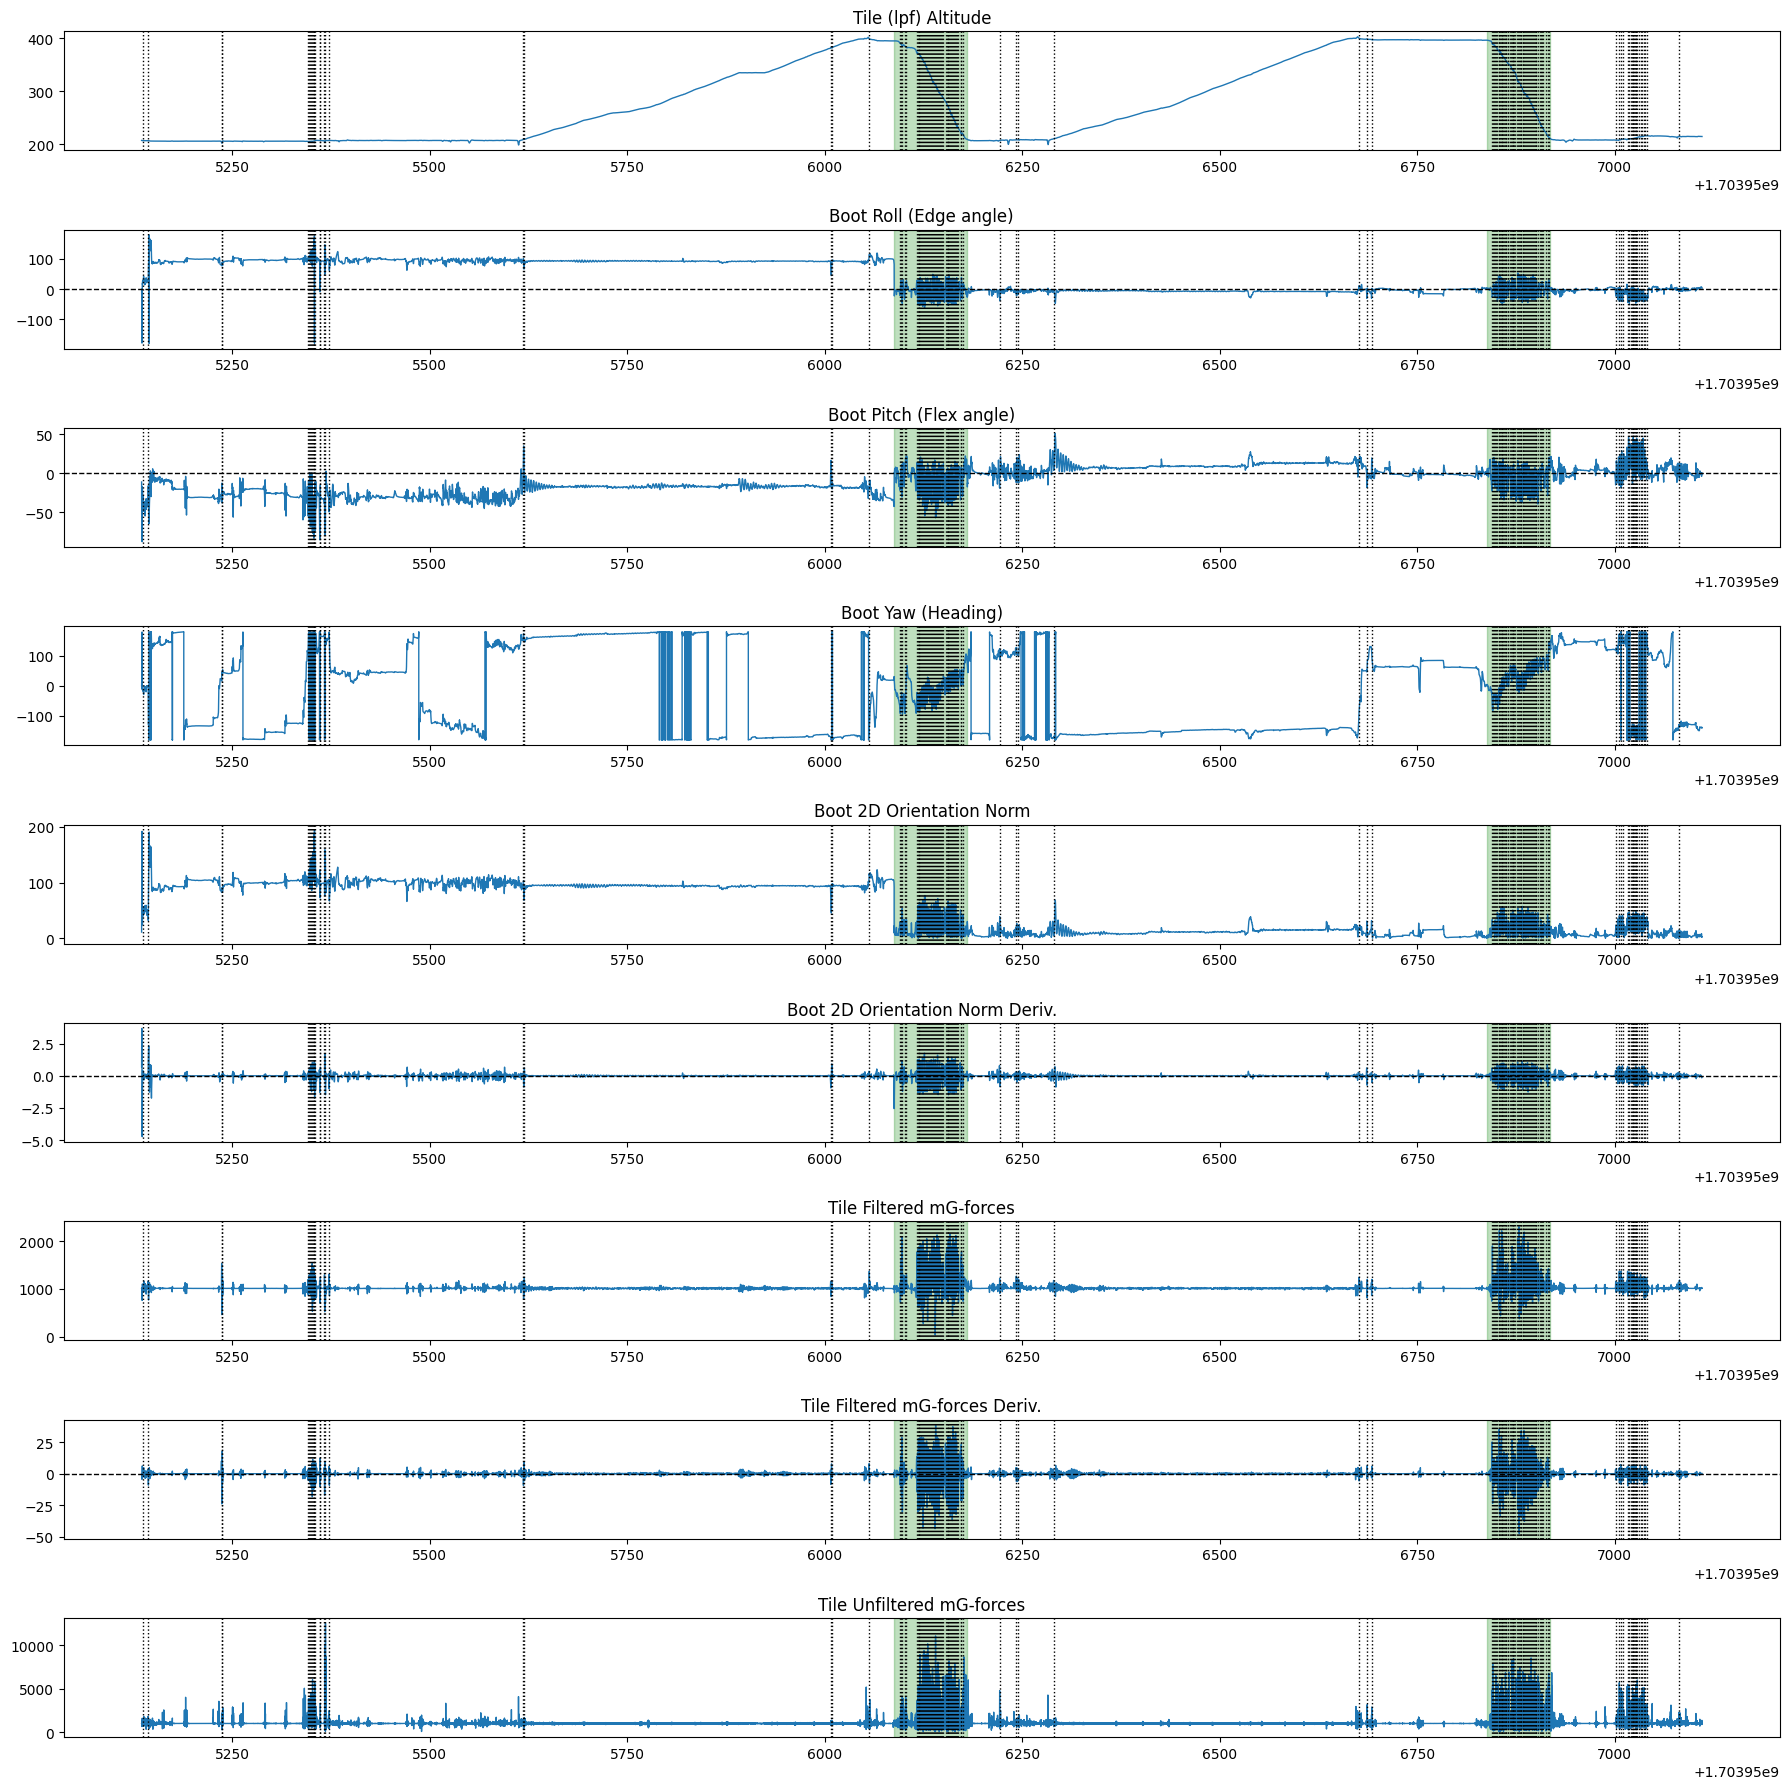

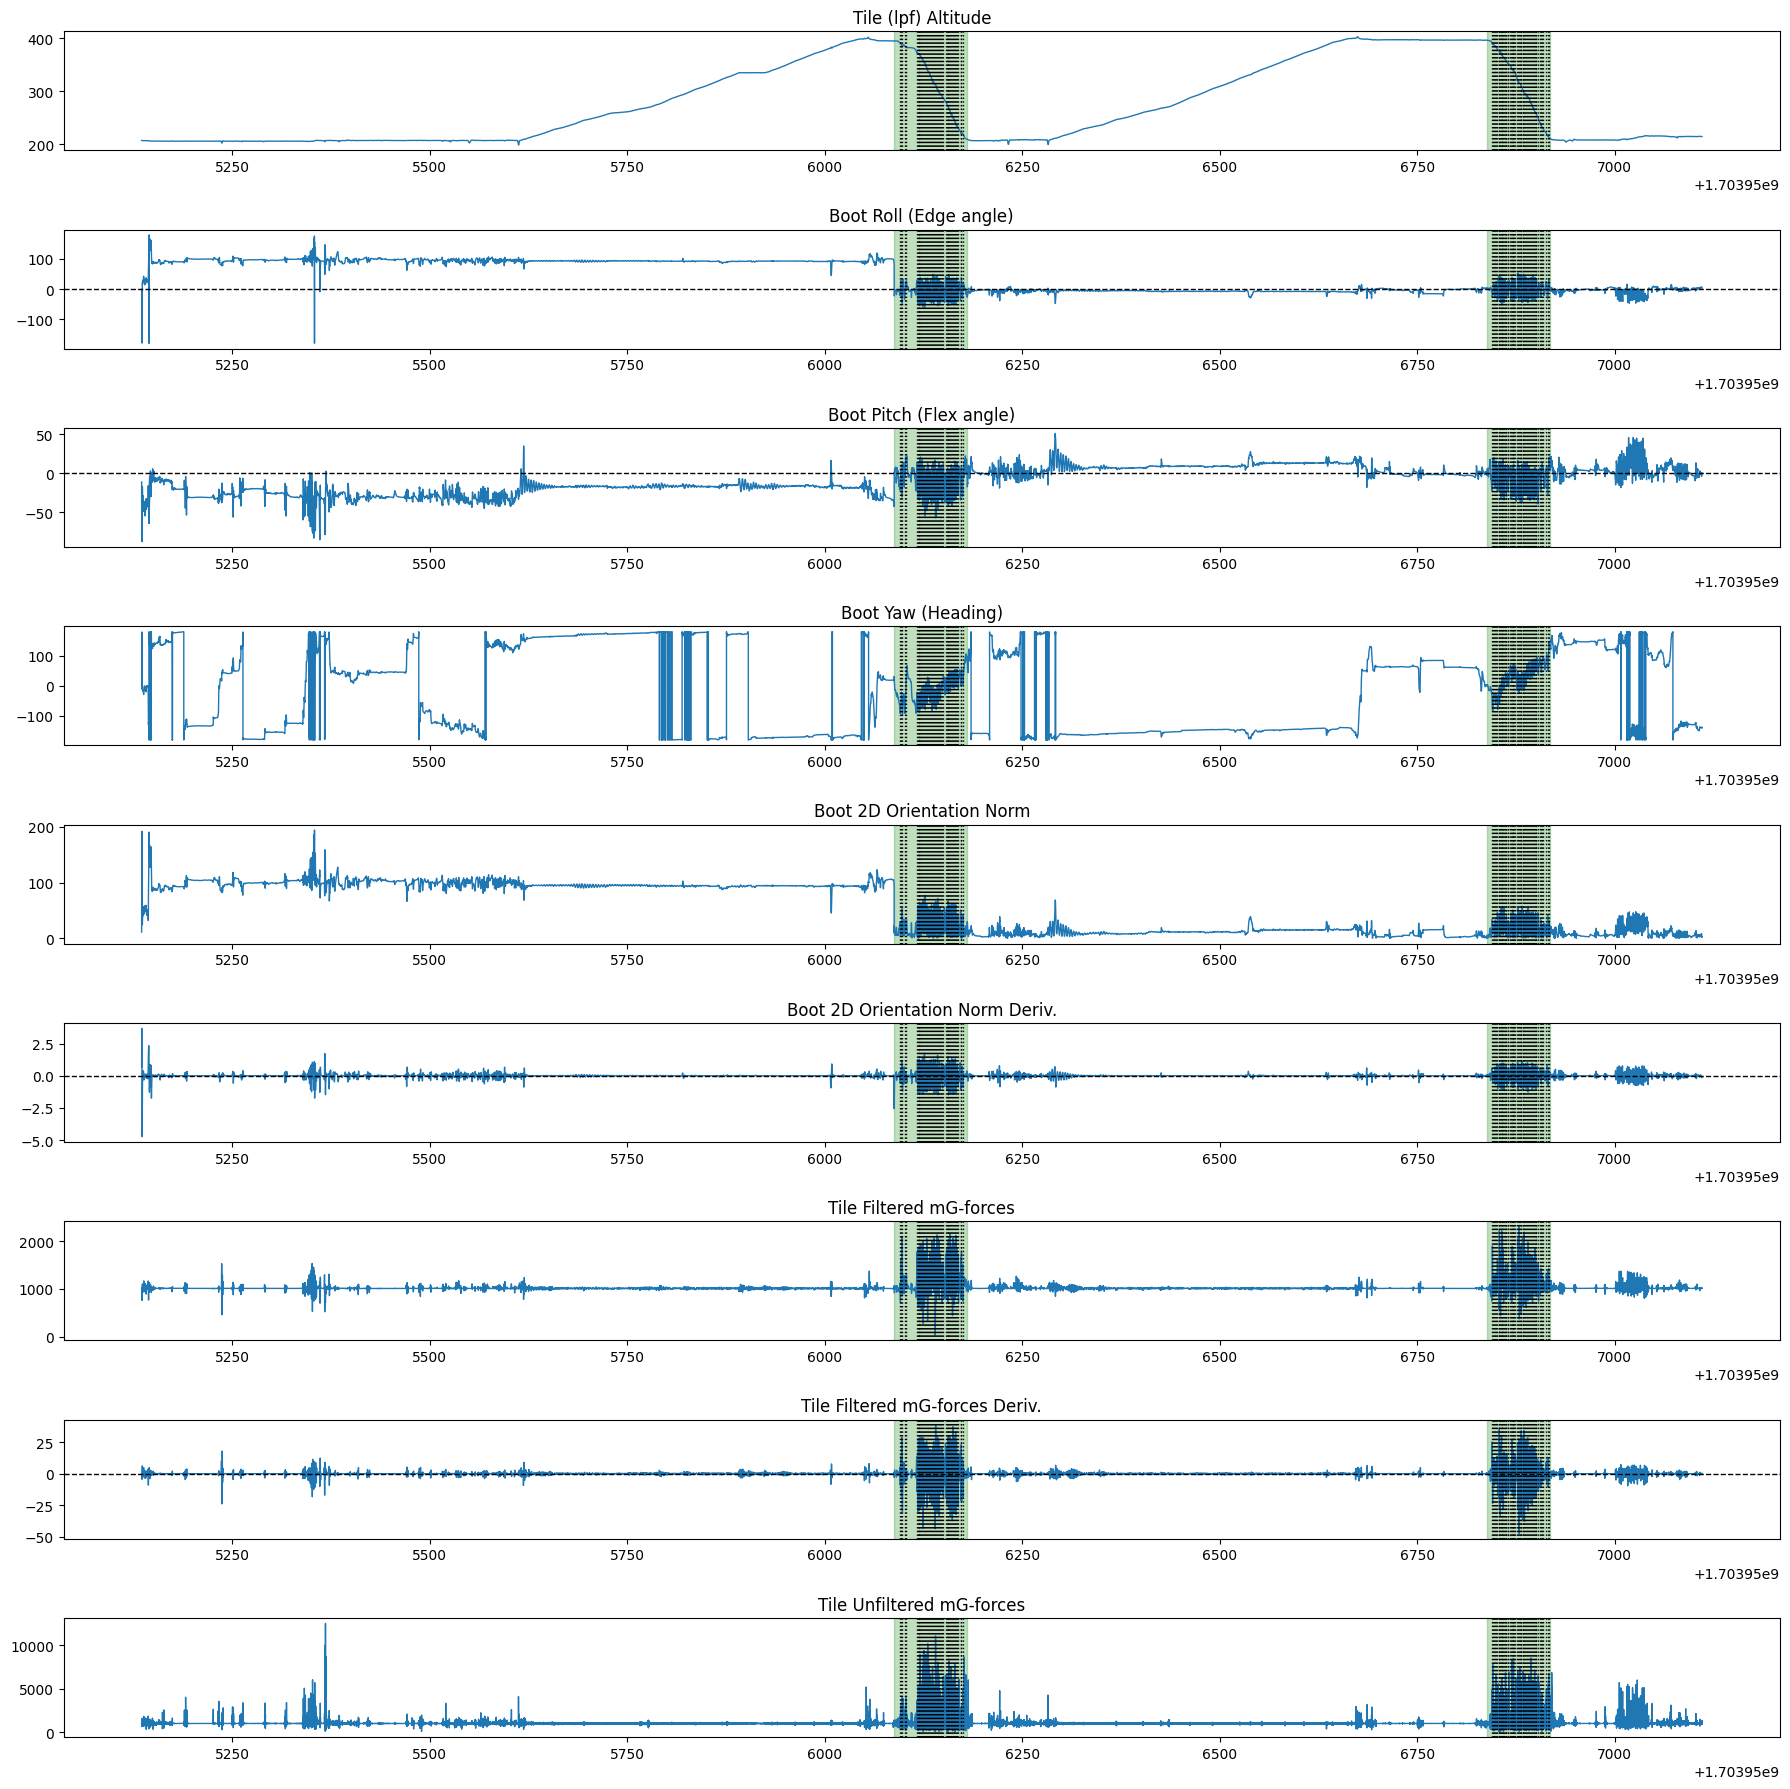

In [9]:
from utilities.sig_proc_np import zeroCrossingIdxsGTThInsideRanges


zc_mG_lpf_idxs = zeroCrossingIndicesWithTh(session_2023_12_30.tile.d_mG_lpf_dt, th=0.25)
zc_mG_lpf_run_idxs = zeroCrossingIdxsGTThInsideRanges(
    session_2023_12_30.tile.d_mG_lpf_dt,
    0.25,
    session_2023_12_30.tile.downhill_idxs
)

print('mG lpf zero crossings > th:', zc_mG_lpf_idxs.shape[0])
print('mG lpf zero crossings > th runs only:', zc_mG_lpf_run_idxs.shape[0])

_ = plotTurnAnalytics(session_2023_12_30.tile, zc_mG_lpf_idxs.tolist())
_ = plotTurnAnalytics(session_2023_12_30.tile, zc_mG_lpf_run_idxs.tolist())

#### Looking more Closely...

Plotting points of high local g-force maxima found, they line up well with the final moments of a turn- where peak g-forces would be felt due to peak leg compression. Consider the troughs and peaks of the roll angle since those are left vs. right turns.

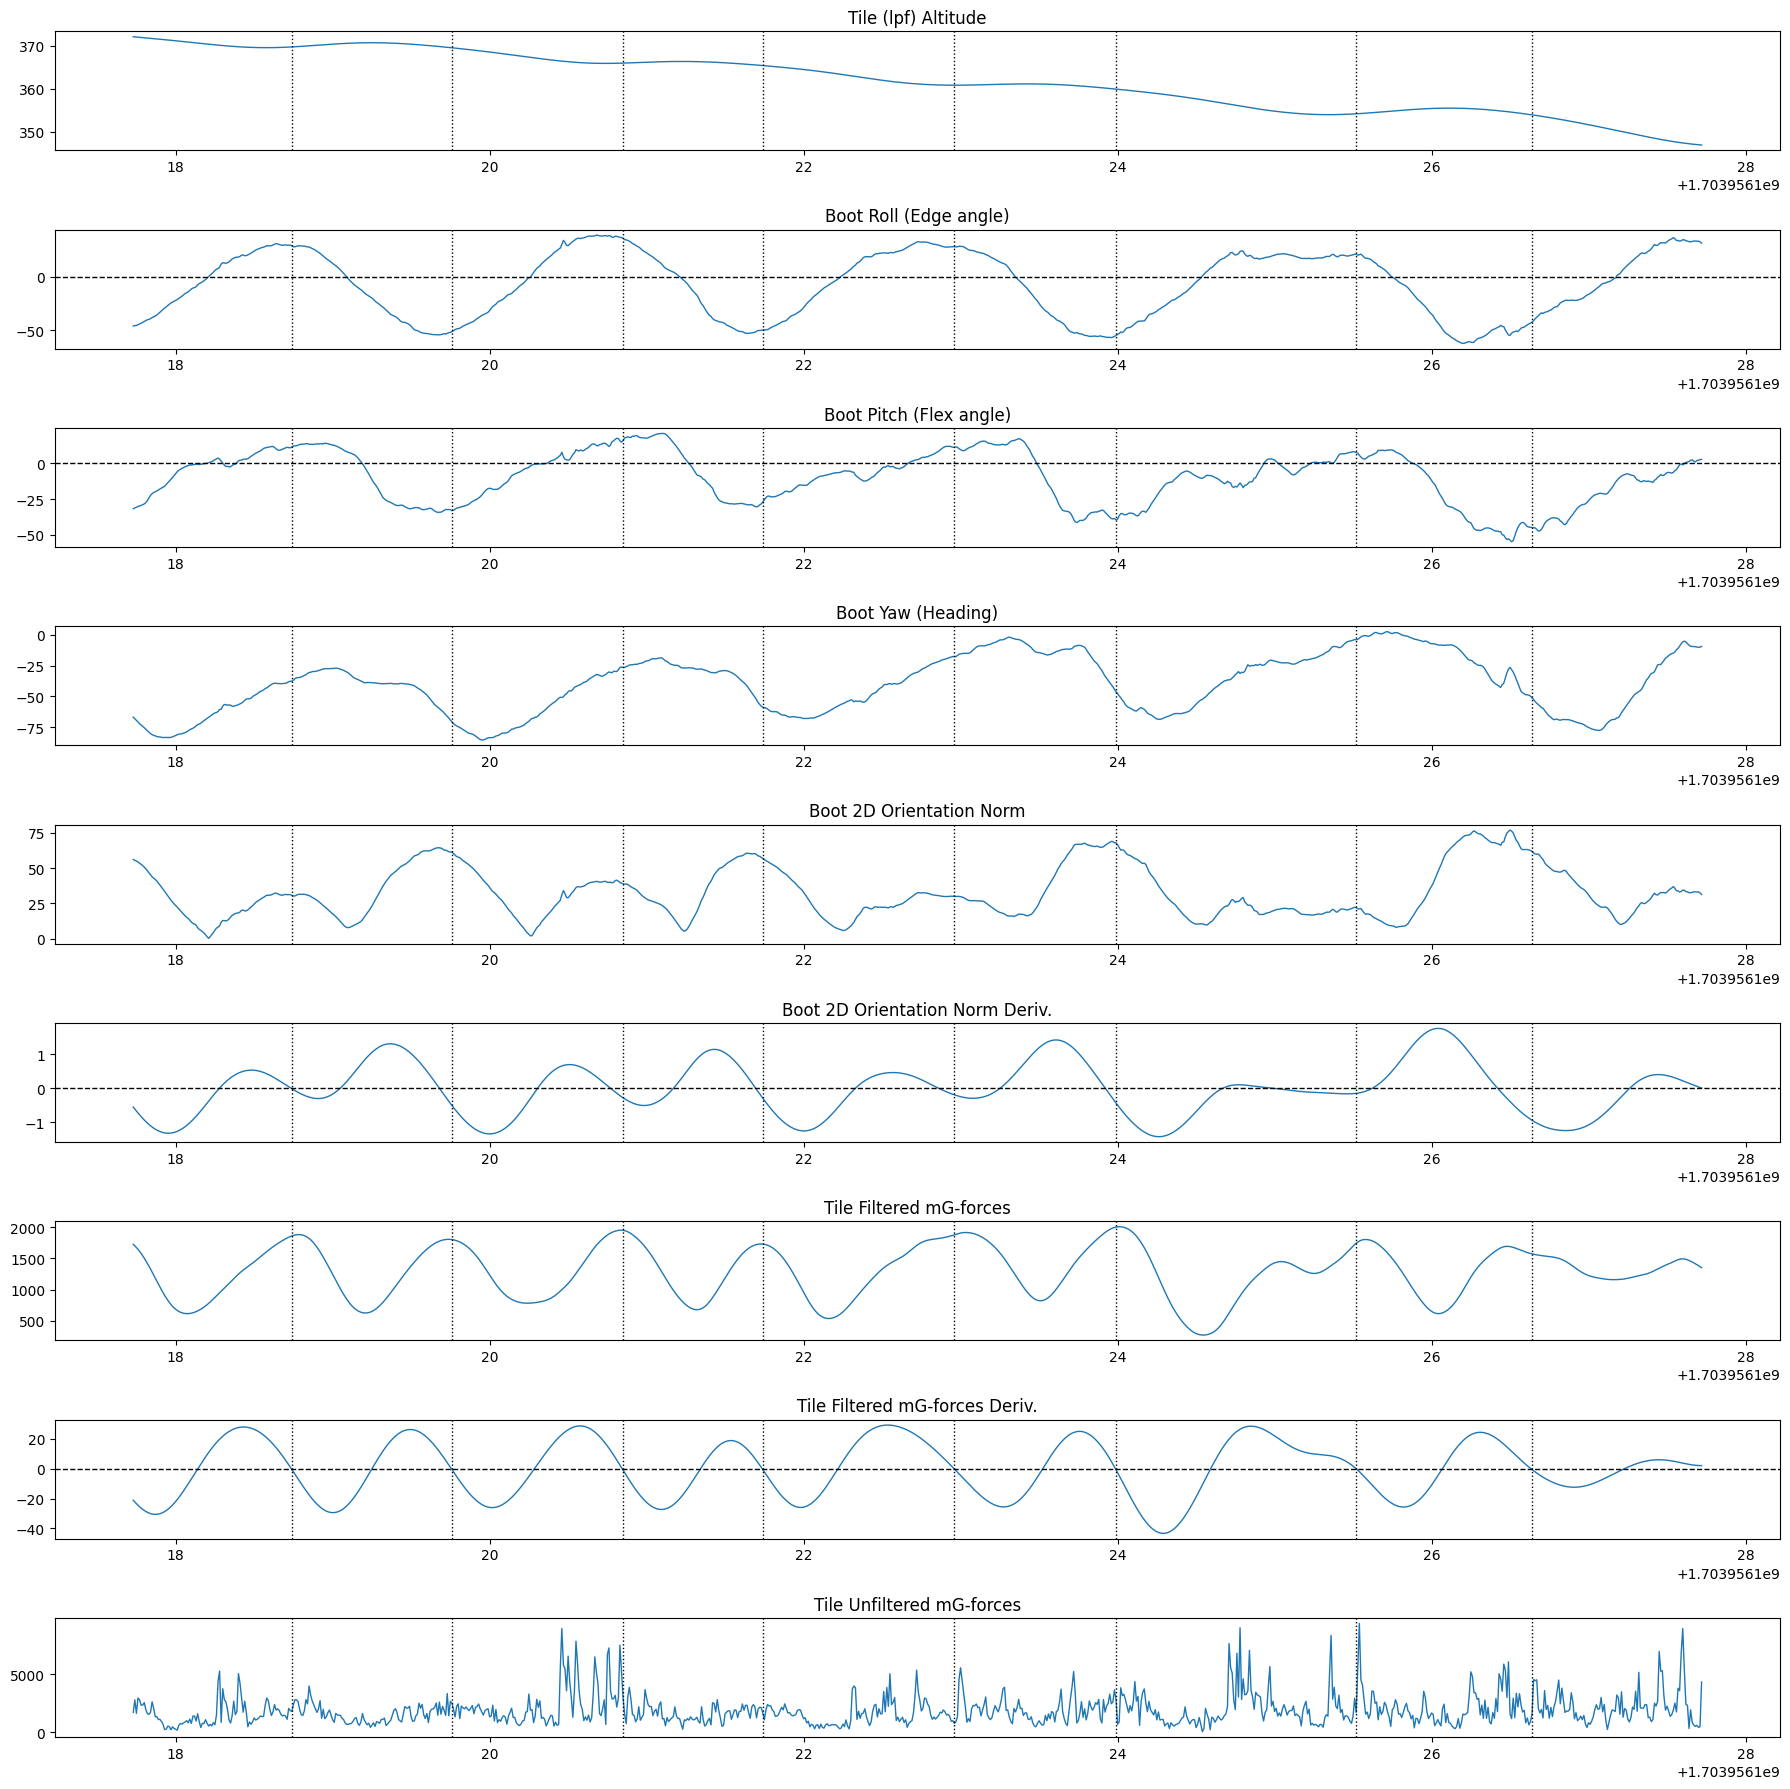

In [7]:
from utilities.plotting import plotTurnAnalytics

brackets = [[r[1]+3000, r[1]+4000] for r in session_2023_12_30.tile.static_registration.ranges]
_ = plotTurnAnalytics(session_2023_12_30.tile, zc_mG_lpf_idxs, brackets[0])

## Statistical Tests

- decreasing alt trend
- roll observes local maxima minima before max g-force compression (id'd from the deriv)
- zero crossing in roll previous to max compression
- magnitude of g-force at peak compression
- magnitude of roll at peak compression
- magnitude of peak roll previous to peak compression
- timing of peak roll from peak compression
- heading observed peak/trough before peak compression
- timing of peak/trough heading before peak compression

Not worth looking at pitch, since its oscillation only represents to the turns where it's the inside boot.

### Methods

Following the previous jump method, 

1. identify mG peaks (that pass d/dx th) during runs and assign as a turn obj instance
2. each turn obj instance will run a suite of protocols to report a confidence